## Esse notebook tem o objetivo de documentar a evolução do projeto

In [1]:
import pyspark
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import SQLContext
import json
from pyspark.sql.functions import mean, min, max
import matplotlib.pyplot as plt


from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("MinhaAplicacao").getOrCreate()
sc = spark.sparkContext
sqlContext = pyspark.SQLContext(sc)

df= spark.read.json('../yelp_academic_dataset_review.json')
df.show()

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|ujmEBvifdJM6h6RLv...|   0|2013-05-07 04:34:36|    1|Q1sbwvVQXV2734tPg...|  1.0|Total bill for th...|     6|hG7b0MtEbXx5QzbzE...|
|NZnhc2sEQy3RmzKTZ...|   0|2017-01-14 21:30:33|    0|GJXCdrto3ASJOqKeV...|  5.0|I *adore* Travis ...|     0|yXQM5uF2jS6es16SJ...|
|WTqjgwHlXbSFevF32...|   0|2016-11-09 20:09:03|    0|2TzJjDVDEuAW6MR5V...|  5.0|I have to say tha...|     3|n6-Gk65cPZL6Uz8qR...|
|ikCg8xy5JIg_NGPx-...|   0|2018-01-09 20:56:38|    0|yi0R0Ugj_xUx_Nek0...|  5.0|Went in for a lun...|     0|dacAIZ6fTM6mqwW5u...|
|b1b1eb3uo-w561D0Z...|   0|2018-01-30 23:07:38|    0|11a8sVPMUFtaC7_AB...|  1.0|Today was 

In [6]:
print((df.count(), len(df.columns)))

(6685900, 9)


In [7]:
df.first()

Row(business_id='ujmEBvifdJM6h6RLv4wQIg', cool=0, date='2013-05-07 04:34:36', funny=1, review_id='Q1sbwvVQXV2734tPgoKj4Q', stars=1.0, text='Total bill for this horrible service? Over $8Gs. These crooks actually had the nerve to charge us $69 for 3 pills. I checked online the pills can be had for 19 cents EACH! Avoid Hospital ERs at all costs.', useful=6, user_id='hG7b0MtEbXx5QzbzE6C_VA')

In [8]:
df.describe().show()

+-------+--------------------+------------------+-------------------+-------------------+--------------------+------------------+------------------------------------+------------------+--------------------+
|summary|         business_id|              cool|               date|              funny|           review_id|             stars|                                text|            useful|             user_id|
+-------+--------------------+------------------+-------------------+-------------------+--------------------+------------------+------------------------------------+------------------+--------------------+
|  count|             6685900|           6685900|            6685900|            6685900|             6685900|           6685900|                             6685900|           6685900|             6685900|
|   mean|                null|0.5787708461089756|               null|0.48276671801851656|                null|3.7161993149762935|                                null|1.3541

In [14]:
gr = df.agg(countDistinct("business_id"))
gr.show()

+---------------------------+
|count(DISTINCT business_id)|
+---------------------------+
|                     192606|
+---------------------------+



## Explorando as possibilidades com um business especifico

In [46]:
def get_business(biz_id):   
    df_b = df.filter(df['business_id'] == biz_id).select('stars','date','text','useful') # Separa o df com somente o business de intresse

    df_size = df_b.count() # Conta o numero de reviews
    avg_rating = (df_b.agg({"stars": "avg"})).first()[0] # Faz a media de reviews
    std = (df_b.agg({"stars": "stddev"})).first()[0] # Calculda o desvio padrao
    worst = df_b.orderBy(asc("stars"),desc("useful")).limit(1).first() # Seleciona a review com nota mais baixa e mais marcada como 'useful'
    
    print("Quantidade de Reviews: ", df_size)
    print("Media das Avaliacoes: ", avg_rating)
    print("Desvio padrao: ", std)
    print("\nPior review: ", worst['stars'], "estrelas em ", worst['date'])
    print("Comentario da pior review: ", worst['text'])

In [47]:
#biz_id = 'Gyrez6K8f1AyR7dzW9fvAw'
biz_id = '2zmKeAu1mSyT9gnFxdmQGw'
#NZnhc2sEQy3RmzKTZnqtwQ

get_business(biz_id)

Quantidade de Reviews:  9
Media das Avaliacoes:  5.0
Desvio padrao:  0.0

Pior review:  5.0 estrelas em  2012-05-08 00:34:36
Comentario da pior review:  I highly recommend Barbie's.  They are very responsive and professional and took about 25 minutes to come over and meet our dog and understand her needs before their first official visit.  Our dog loves our pet sitter from Barbie's and she always provides wonderful notes and emails about her visits about my pup when I'm gone.  They are great!


## Pegando informacoes sobre o business na sua pagina no Yelp

In [61]:
from bs4 import BeautifulSoup
import requests
import re

def url_to_string(url):
    res = requests.get(url)
    html = res.text
    soup = BeautifulSoup(html, 'html5lib')
    for script in soup(["script", "style", 'aside']):
        script.extract()
    return " ".join(re.split(r'[\n\t]+', soup.get_text()))

In [62]:
ny_bb = url_to_string('https://www.yelp.com/biz/'+biz_id)
# article = nlp(ny_bb)
# len(article.ents)

In [63]:
#ny_bb

In [81]:
res = requests.get('https://www.yelp.com/biz_attribute?biz_id=FKQUxOfW_W5R4OTut4G1Vw')#'https://www.yelp.com/biz/'+biz_id)
html =res.text
soup = BeautifulSoup(html, 'html5lib')


In [103]:
import bs4
res.raise_for_status()
recipeSoup = bs4.BeautifulSoup(res.text, "html.parser")
type(recipeSoup)

price = soup.findAll("input",{"type":"text"}) # price of restaurant
name = price[4] 
addr = price[5] 
city = price[7] 
zipcode = price[8] 
phone = price[9] 

In [118]:
price

[<input aria-hidden="true" autocomplete="off" class="input__373c0__1POmY hidden-input__373c0__3SQQL" disabled="" placeholder=" " spellcheck="false" tabindex="-1" type="text" value=""/>,
 <input aria-autocomplete="list" autocomplete="off" class="input__373c0__1POmY original-input__373c0__lpd54" data-testid="suggest-desc-input" id="search_description" name="find_desc" placeholder="tacos, cheap dinner, Max’s" tabindex="0" type="text" value=""/>,
 <input aria-hidden="true" autocomplete="off" class="input__373c0__1POmY hidden-input__373c0__3SQQL" disabled="" placeholder=" " spellcheck="false" tabindex="-1" type="text" value=""/>,
 <input aria-autocomplete="list" autocomplete="off" class="input__373c0__1POmY original-input__373c0__lpd54" data-testid="suggest-location-input" id="search_location" placeholder="address, neighborhood, city, state or zip" tabindex="0" type="text" value="San Francisco, CA"/>,
 <input class="text" id="attr_BusinessName" name="BusinessName" placeholder="Mel’s Diner" 

In [119]:
pip install yelp

  Created wheel for yelp: filename=yelp-1.0.2-cp37-none-any.whl size=11813 sha256=4ff57d5a7822379e44d96b578d3e0050024957e791aafc7924b0c8551d1891b9
  Stored in directory: C:\Users\guipl\AppData\Local\pip\Cache\wheels\a5\1f\cb\cd71331e931f7b0e719d4319b8cc14e34faabac6946ff35aa4
Successfully built yelp
Note: you may need to restart the kernel to use updated packages.


AttributeError: 'Client' object has no attribute 'business'

In [15]:
gr = df.agg(countDistinct("business_id"))
gr.show()

+---------------------------+
|count(DISTINCT business_id)|
+---------------------------+
|                     192606|
+---------------------------+



In [43]:
df_biz = df.select("business_id").distinct()

print((df_biz.count(), len(df_biz.columns)))
df_biz.show()

(192606, 1)
+--------------------+
|         business_id|
+--------------------+
|f4mh1Y0rnvbJRfQ3j...|
|cKwg6HFaLYXl7Ar0r...|
|jcpgiXF0PCyS9hrvq...|
|R_M4P9XetEM-aLE7e...|
|DEBqmgxv2yhJ93LqG...|
|Cml4Yt5cTx64cOMan...|
|bo3SQVtErnMOqO6lk...|
|Cl-xl1vTUwHeaGgBx...|
|oIEmXWLtoh5blz-iw...|
|Op2IR4FffXZ5KXYFn...|
|yB5FMuc9Y3oyhsOmu...|
|cEqOh78v1g1RCWHyu...|
|lt8IW9Bpy9GMeKGxy...|
|uC3qwaxsOkdJzpOc0...|
|686oeWNsbc-aczplC...|
|gPuxh3HNvoVt8aWVW...|
|mA27CG2U3ytmkxIGV...|
|x6qH9HXhzuKM03jcZ...|
|74LU6K2ro5AQXKT0J...|
|TdefcbsFAj6WXHwlG...|
+--------------------+
only showing top 20 rows



In [46]:
for i in range(20):
    print(df_biz[0][i])

Column<b'business_id[0]'>
Column<b'business_id[1]'>
Column<b'business_id[2]'>
Column<b'business_id[3]'>
Column<b'business_id[4]'>
Column<b'business_id[5]'>
Column<b'business_id[6]'>
Column<b'business_id[7]'>
Column<b'business_id[8]'>
Column<b'business_id[9]'>
Column<b'business_id[10]'>
Column<b'business_id[11]'>
Column<b'business_id[12]'>
Column<b'business_id[13]'>
Column<b'business_id[14]'>
Column<b'business_id[15]'>
Column<b'business_id[16]'>
Column<b'business_id[17]'>
Column<b'business_id[18]'>
Column<b'business_id[19]'>


In [55]:
def customFunction(row):
    print(row.business_id)
    return (row.business_id)

sample2 = df_biz.rdd.map(customFunction)
sample2

PythonRDD[179] at RDD at PythonRDD.scala:53

## Iterando por busines

In [211]:
df_biz = df.select("business_id").distinct()

# for row in df_biz.rdd.collect():
#     print(row.business_id)


## Graficos por tempo

In [59]:
def business_ratingxtime(biz_id):   
    df_b = df.filter(df['business_id'] == biz_id).select('stars','date') # Separa o df com somente o business de intresse

    df_size = df_b.count() # Conta o numero de reviews
    avg_rating = (df_b.agg({"stars": "avg"})).first()[0] # Faz a media de reviews
    std = (df_b.agg({"stars": "stddev"})).first()[0] # Calculda o desvio padrao
    
    print("Quantidade de Reviews: ", df_size)
    print("Media das Avaliacoes: ", avg_rating)


In [95]:
df_g = df_b.groupby('date')
df_g.show()

AttributeError: 'GroupedData' object has no attribute 'show'

In [72]:
df_baa.orderBy(asc("date")) # Seleciona a review com nota mais baixa e mais marcada como 'useful'
df_baa.show()

+-----+-------------------+
|stars|               date|
+-----+-------------------+
|  4.0|2008-12-05 17:27:54|
|  3.0|2013-08-16 02:29:39|
|  4.0|2017-12-17 15:57:12|
|  1.0|2014-08-13 10:59:45|
|  5.0|2017-09-10 14:51:04|
|  2.0|2014-11-15 05:03:31|
|  5.0|2015-09-25 19:48:14|
|  3.0|2017-01-29 15:06:34|
|  4.0|2012-04-06 16:12:57|
|  4.0|2010-11-29 19:32:11|
|  4.0|2017-10-12 16:27:43|
|  1.0|2013-06-01 16:25:56|
|  3.0|2018-07-09 19:11:15|
|  5.0|2016-10-31 15:28:20|
|  3.0|2011-01-17 19:26:22|
|  3.0|2016-03-21 01:33:52|
|  1.0|2014-02-11 10:28:28|
|  2.0|2018-09-07 22:15:30|
|  4.0|2012-09-16 20:06:07|
|  4.0|2015-12-12 21:47:56|
+-----+-------------------+
only showing top 20 rows



In [93]:




df_baa = df.filter(df['business_id'] == 'tiQQqJ5ymf_XWzyF9ywArw').select('stars','date') # Separa o df com somente o business de intresse

df_baa = df_baa.withColumn("date_only",to_date(col("date"))) # tira as horas minutos e segundos para poder dar o groupBy
df_baa.orderBy(unix_timestamp("date_only", "yyyy-mm-dd")).show() 


+-----+-------------------+----------+
|stars|               date| date_only|
+-----+-------------------+----------+
|  4.0|2008-12-05 17:27:54|2008-12-05|
|  2.0|2009-01-28 22:33:05|2009-01-28|
|  4.0|2009-04-10 18:44:07|2009-04-10|
|  4.0|2009-09-12 04:36:45|2009-09-12|
|  3.0|2009-11-08 19:59:14|2009-11-08|
|  3.0|2010-06-30 22:30:10|2010-06-30|
|  2.0|2010-07-25 01:49:05|2010-07-25|
|  4.0|2010-11-29 19:32:11|2010-11-29|
|  3.0|2011-01-17 19:26:22|2011-01-17|
|  4.0|2011-03-14 19:04:57|2011-03-14|
|  5.0|2011-07-25 01:10:48|2011-07-25|
|  5.0|2011-09-14 18:17:24|2011-09-14|
|  5.0|2011-10-21 15:14:32|2011-10-21|
|  4.0|2012-01-14 10:09:15|2012-01-14|
|  4.0|2012-04-06 16:12:57|2012-04-06|
|  3.0|2012-04-21 01:34:28|2012-04-21|
|  4.0|2012-05-16 02:49:59|2012-05-16|
|  3.0|2012-08-10 23:47:28|2012-08-10|
|  4.0|2012-09-16 20:06:07|2012-09-16|
|  4.0|2013-04-01 16:55:07|2013-04-01|
+-----+-------------------+----------+
only showing top 20 rows



In [96]:
df_baa.count()

67

In [111]:
df_baaMean = df_baa.groupBy("date_only").agg({'stars':'avg'})
df_baaMean = df_baaMean.select(col("date_only"), col("avg(stars)").alias("avg_stars"))

df_baaMean = df_baaMean.orderBy(unix_timestamp("date_only", "yyyy-mm-dd"))
df_baaMean.show()

+----------+---------+
| date_only|avg_stars|
+----------+---------+
|2008-12-05|      4.0|
|2009-01-28|      2.0|
|2009-04-10|      4.0|
|2009-09-12|      4.0|
|2009-11-08|      3.0|
|2010-06-30|      3.0|
|2010-07-25|      2.0|
|2010-11-29|      4.0|
|2011-01-17|      3.0|
|2011-03-14|      4.0|
|2011-07-25|      5.0|
|2011-09-14|      5.0|
|2011-10-21|      5.0|
|2012-01-14|      4.0|
|2012-04-06|      4.0|
|2012-04-21|      3.0|
|2012-05-16|      4.0|
|2012-08-10|      3.0|
|2012-09-16|      4.0|
|2013-04-01|      4.0|
+----------+---------+
only showing top 20 rows



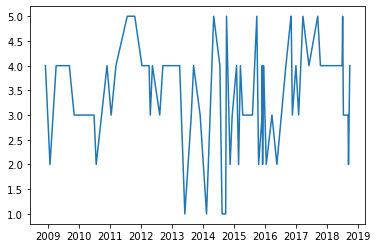

In [113]:
import matplotlib.pyplot as plt

y_ans_val = [val.avg_stars for val in df_baaMean.select('avg_stars').collect()]
x_ts = [val.date_only for val in df_baaMean.select('date_only').collect()]

plt.plot(x_ts, y_ans_val)
plt.show()

## Reviws por dia

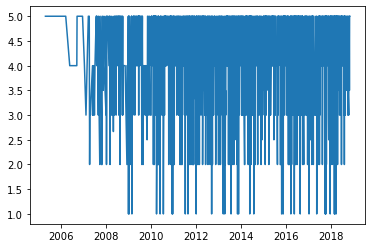

In [124]:
df_baa = df.filter(df['business_id'] == '--9e1ONYQuAa-CB_Rrw7Tw').select('stars','date') # Separa o df com somente o business de intresse

df_baa = df_baa.withColumn("date_only",to_date(col("date"))) # tira as horas minutos e segundos para poder dar o groupBy
#df_baa.orderBy(unix_timestamp("date_only", "yyyy-mm-dd")).show() 

df_baaMean = df_baa.groupBy("date_only").agg({'stars':'avg'})
df_baaMean = df_baaMean.select(col("date_only"), col("avg(stars)").alias("avg_stars"))

df_baaMean = df_baaMean.orderBy(unix_timestamp("date_only", "yyyy-mm-dd"))
#df_baaMean.show()

import matplotlib.pyplot as plt

y_ans_val = [val.avg_stars for val in df_baaMean.select('avg_stars').collect()]
x_ts = [val.date_only for val in df_baaMean.select('date_only').collect()]

plt.plot(x_ts, y_ans_val)
plt.show()

In [121]:
import pyspark.sql.functions as F
@F.udf
def mode(x):
    from collections import Counter
    return Counter(x).most_common(1)[0][0]

agg_expr = [mode(F.collect_list(col)).alias(col) for col in ['business_id']]
df.groupBy('business_id').agg(*agg_expr).first()


Row(business_id='--9e1ONYQuAa-CB_Rrw7Tw', business_id='--9e1ONYQuAa-CB_Rrw7Tw')

In [125]:
df_baa.count()

1661

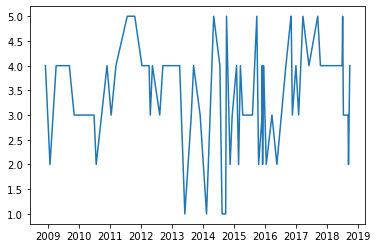

In [126]:
df_baa = df.filter(df['business_id'] == 'tiQQqJ5ymf_XWzyF9ywArw').select('stars','date') # Separa o df com somente o business de intresse

df_baa = df_baa.withColumn("date_only",to_date(col("date"))) # tira as horas minutos e segundos para poder dar o groupBy
#df_baa.orderBy(unix_timestamp("date_only", "yyyy-mm-dd")).show() 

df_baaMean = df_baa.groupBy("date_only").agg({'stars':'avg'})
df_baaMean = df_baaMean.select(col("date_only"), col("avg(stars)").alias("avg_stars"))

df_baaMean = df_baaMean.orderBy(unix_timestamp("date_only", "yyyy-mm-dd"))
#df_baaMean.show()

import matplotlib.pyplot as plt

y_ans_val = [val.avg_stars for val in df_baaMean.select('avg_stars').collect()]
x_ts = [val.date_only for val in df_baaMean.select('date_only').collect()]

plt.plot(x_ts, y_ans_val)
plt.show()

In [133]:
df_baaY = df_baa.withColumn("year_only",(trunc(df_baa.date, 'year'))) 

df_baaMeanY = df_baaY.groupBy("year_only").agg({'stars':'avg'})
df_baaMeanY = df_baaMeanY.select(col("year_only"), col("avg(stars)").alias("avg_stars"))

df_baaMeanY = df_baaMeanY.orderBy(unix_timestamp("year_only", "yyyy-mm-dd"))

In [134]:
df_baaMeanY.show()

+----------+------------------+
| year_only|         avg_stars|
+----------+------------------+
|2008-01-01|               4.0|
|2009-01-01|              3.25|
|2010-01-01|               3.0|
|2011-01-01|               4.4|
|2012-01-01|3.6666666666666665|
|2013-01-01|               3.0|
|2014-01-01|              2.75|
|2015-01-01|3.3333333333333335|
|2016-01-01|               3.5|
|2017-01-01| 4.142857142857143|
|2018-01-01|               3.5|
+----------+------------------+



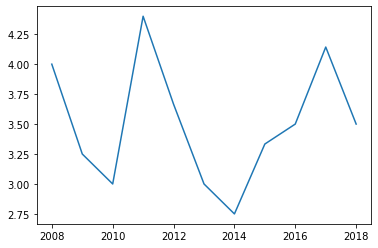

In [135]:
y_ans_val = [val.avg_stars for val in df_baaMeanY.select('avg_stars').collect()]
x_ts = [val.year_only for val in df_baaMeanY.select('year_only').collect()]

plt.plot(x_ts, y_ans_val)
plt.show()

In [199]:
df_baaY = df_baaY.withColumn("date_only",to_date(col("date"))) # tira as horas minutos e segundos para poder dar o groupBy
df_baaY = df_baaY.orderBy(unix_timestamp("year_only", "yyyy-mm-dd"))

df_baaY1 = df_baaY.filter(df['stars'] == 1).select('stars','year_only') 
df_baaY1 = df_baaY1.groupBy('year_only').count()
df_baaY1 = df_baaY1.select(col("year_only"), col("count").alias("count_stars"))
df_baaY1 = df_baaY1.orderBy(unix_timestamp("year_only", "yyyy-mm-dd"))

df_baaY2 = df_baaY.filter(df['stars'] == 2).select('stars','year_only') 
df_baaY2 = df_baaY2.groupBy('year_only').count()
df_baaY2 = df_baaY2.select(col("year_only"), col("count").alias("count_stars"))
df_baaY2 = df_baaY2.orderBy(unix_timestamp("year_only", "yyyy-mm-dd"))

df_baaY3 = df_baaY.filter(df['stars'] == 3).select('stars','year_only') 
df_baaY3 = df_baaY3.groupBy('year_only').count()
df_baaY3 = df_baaY3.select(col("year_only"), col("count").alias("count_stars"))
df_baaY3 = df_baaY3.orderBy(unix_timestamp("year_only", "yyyy-mm-dd"))

df_baaY4 = df_baaY.filter(df['stars'] == 4).select('stars','year_only') 
df_baaY4 = df_baaY4.groupBy('year_only').count()
df_baaY4 = df_baaY4.select(col("year_only"), col("count").alias("count_stars"))
df_baaY4 = df_baaY4.orderBy(unix_timestamp("year_only", "yyyy-mm-dd"))

df_baaY5 = df_baaY.filter(df['stars'] == 5).select('stars','year_only') 
df_baaY5 = df_baaY5.groupBy('year_only').count()
df_baaY5 = df_baaY5.select(col("year_only"), col("count").alias("count_stars"))
df_baaY5 = df_baaY5.orderBy(unix_timestamp("year_only", "yyyy-mm-dd"))


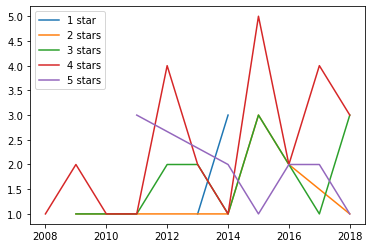

In [232]:
df_baa = df.filter(df['business_id'] == 'tiQQqJ5ymf_XWzyF9ywArw').select('stars','date') # Separa o df com somente o business de intresse
df_baaY = df_baa.withColumn("year_only",(trunc(df_baa.date, 'year'))) 

df_baaY = df_baaY.withColumn("date_only",to_date(col("date"))) # tira as horas minutos e segundos para poder dar o groupBy
df_baaY = df_baaY.orderBy(unix_timestamp("year_only", "yyyy-mm-dd"))

df_baaY1 = df_baaY.filter(df['stars'] == 1).select('stars','year_only') 
df_baaY1 = df_baaY1.groupBy('year_only').count()
df_baaY1 = df_baaY1.select(col("year_only"), col("count").alias("count_stars"))
df_baaY1 = df_baaY1.orderBy(unix_timestamp("year_only", "yyyy-mm-dd"))

df_baaY2 = df_baaY.filter(df['stars'] == 2).select('stars','year_only') 
df_baaY2 = df_baaY2.groupBy('year_only').count()
df_baaY2 = df_baaY2.select(col("year_only"), col("count").alias("count_stars"))
df_baaY2 = df_baaY2.orderBy(unix_timestamp("year_only", "yyyy-mm-dd"))

df_baaY3 = df_baaY.filter(df['stars'] == 3).select('stars','year_only') 
df_baaY3 = df_baaY3.groupBy('year_only').count()
df_baaY3 = df_baaY3.select(col("year_only"), col("count").alias("count_stars"))
df_baaY3 = df_baaY3.orderBy(unix_timestamp("year_only", "yyyy-mm-dd"))

df_baaY4 = df_baaY.filter(df['stars'] == 4).select('stars','year_only') 
df_baaY4 = df_baaY4.groupBy('year_only').count()
df_baaY4 = df_baaY4.select(col("year_only"), col("count").alias("count_stars"))
df_baaY4 = df_baaY4.orderBy(unix_timestamp("year_only", "yyyy-mm-dd"))

df_baaY5 = df_baaY.filter(df['stars'] == 5).select('stars','year_only') 
df_baaY5 = df_baaY5.groupBy('year_only').count()
df_baaY5 = df_baaY5.select(col("year_only"), col("count").alias("count_stars"))
df_baaY5 = df_baaY5.orderBy(unix_timestamp("year_only", "yyyy-mm-dd"))


y_ans_val1 = [val.count_stars for val in df_baaY1.select('count_stars').collect()]
x_ts1 = [val.year_only for val in df_baaY1.select('year_only').collect()]

y_ans_val2 = [val.count_stars for val in df_baaY2.select('count_stars').collect()]
x_ts2 = [val.year_only for val in df_baaY2.select('year_only').collect()]

y_ans_val3 = [val.count_stars for val in df_baaY3.select('count_stars').collect()]
x_ts3 = [val.year_only for val in df_baaY3.select('year_only').collect()]

y_ans_val4 = [val.count_stars for val in df_baaY4.select('count_stars').collect()]
x_ts4 = [val.year_only for val in df_baaY4.select('year_only').collect()]

y_ans_val5 = [val.count_stars for val in df_baaY5.select('count_stars').collect()]
x_ts5 = [val.year_only for val in df_baaY5.select('year_only').collect()]

plt.plot(x_ts1, y_ans_val1,x_ts2, y_ans_val2,x_ts3, y_ans_val3,x_ts4, y_ans_val4,x_ts5, y_ans_val5)
plt.gca().legend(('1 star','2 stars','3 stars','4 stars','5 stars'))

plt.show()

In [ ]:
df_baaY1.show()

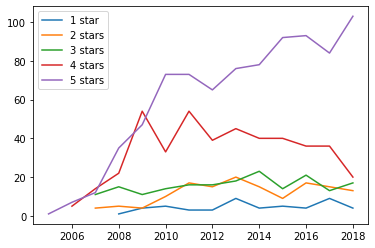

In [231]:
df_baa = df.filter(df['business_id'] == '--9e1ONYQuAa-CB_Rrw7Tw').select('stars','date') # Separa o df com somente o business de intresse
df_baaY = df_baa.withColumn("year_only",(trunc(df_baa.date, 'year'))) 

df_baaY = df_baaY.withColumn("date_only",to_date(col("date"))) # tira as horas minutos e segundos para poder dar o groupBy
df_baaY = df_baaY.orderBy(unix_timestamp("year_only", "yyyy-mm-dd"))

df_baaY1 = df_baaY.filter(df['stars'] == 1).select('stars','year_only') 
df_baaY1 = df_baaY1.groupBy('year_only').count()
df_baaY1 = df_baaY1.select(col("year_only"), col("count").alias("count_stars"))
df_baaY1 = df_baaY1.orderBy(unix_timestamp("year_only", "yyyy-mm-dd"))

df_baaY2 = df_baaY.filter(df['stars'] == 2).select('stars','year_only') 
df_baaY2 = df_baaY2.groupBy('year_only').count()
df_baaY2 = df_baaY2.select(col("year_only"), col("count").alias("count_stars"))
df_baaY2 = df_baaY2.orderBy(unix_timestamp("year_only", "yyyy-mm-dd"))

df_baaY3 = df_baaY.filter(df['stars'] == 3).select('stars','year_only') 
df_baaY3 = df_baaY3.groupBy('year_only').count()
df_baaY3 = df_baaY3.select(col("year_only"), col("count").alias("count_stars"))
df_baaY3 = df_baaY3.orderBy(unix_timestamp("year_only", "yyyy-mm-dd"))

df_baaY4 = df_baaY.filter(df['stars'] == 4).select('stars','year_only') 
df_baaY4 = df_baaY4.groupBy('year_only').count()
df_baaY4 = df_baaY4.select(col("year_only"), col("count").alias("count_stars"))
df_baaY4 = df_baaY4.orderBy(unix_timestamp("year_only", "yyyy-mm-dd"))

df_baaY5 = df_baaY.filter(df['stars'] == 5).select('stars','year_only') 
df_baaY5 = df_baaY5.groupBy('year_only').count()
df_baaY5 = df_baaY5.select(col("year_only"), col("count").alias("count_stars"))
df_baaY5 = df_baaY5.orderBy(unix_timestamp("year_only", "yyyy-mm-dd"))


y_ans_val1 = [val.count_stars for val in df_baaY1.select('count_stars').collect()]
x_ts1 = [val.year_only for val in df_baaY1.select('year_only').collect()]

y_ans_val2 = [val.count_stars for val in df_baaY2.select('count_stars').collect()]
x_ts2 = [val.year_only for val in df_baaY2.select('year_only').collect()]

y_ans_val3 = [val.count_stars for val in df_baaY3.select('count_stars').collect()]
x_ts3 = [val.year_only for val in df_baaY3.select('year_only').collect()]

y_ans_val4 = [val.count_stars for val in df_baaY4.select('count_stars').collect()]
x_ts4 = [val.year_only for val in df_baaY4.select('year_only').collect()]

y_ans_val5 = [val.count_stars for val in df_baaY5.select('count_stars').collect()]
x_ts5 = [val.year_only for val in df_baaY5.select('year_only').collect()]

plt.plot(x_ts1, y_ans_val1,x_ts2, y_ans_val2,x_ts3, y_ans_val3,x_ts4, y_ans_val4,x_ts5, y_ans_val5)
plt.gca().legend(('1 star','2 stars','3 stars','4 stars','5 stars'))

plt.show()

In [224]:
df_baa.count()

0

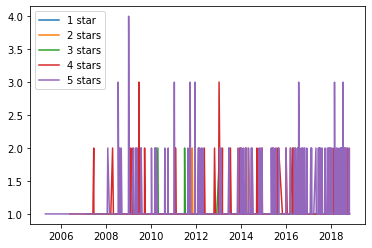

In [225]:
df_baa = df.filter(df['business_id'] == '--9e1ONYQuAa-CB_Rrw7Tw').select('stars','date') # Separa o df com somente o business de intresse
df_baaY = df_baa.withColumn("month_only",(trunc(df_baa.date, 'month'))) 

df_baaY = df_baaY.withColumn("month_only",to_date(col("date"))) # tira as horas minutos e segundos para poder dar o groupBy
df_baaY = df_baaY.orderBy(unix_timestamp("month_only", "yyyy-mm-dd"))

df_baaY1 = df_baaY.filter(df['stars'] == 1).select('stars','month_only') 
df_baaY1 = df_baaY1.groupBy('month_only').count()
df_baaY1 = df_baaY1.select(col("month_only"), col("count").alias("count_stars"))
df_baaY1 = df_baaY1.orderBy(unix_timestamp("month_only", "yyyy-mm-dd"))

df_baaY2 = df_baaY.filter(df['stars'] == 2).select('stars','month_only') 
df_baaY2 = df_baaY2.groupBy('month_only').count()
df_baaY2 = df_baaY2.select(col("month_only"), col("count").alias("count_stars"))
df_baaY2 = df_baaY2.orderBy(unix_timestamp("month_only", "yyyy-mm-dd"))

df_baaY3 = df_baaY.filter(df['stars'] == 3).select('stars','month_only') 
df_baaY3 = df_baaY3.groupBy('month_only').count()
df_baaY3 = df_baaY3.select(col("month_only"), col("count").alias("count_stars"))
df_baaY3 = df_baaY3.orderBy(unix_timestamp("month_only", "yyyy-mm-dd"))

df_baaY4 = df_baaY.filter(df['stars'] == 4).select('stars','month_only') 
df_baaY4 = df_baaY4.groupBy('month_only').count()
df_baaY4 = df_baaY4.select(col("month_only"), col("count").alias("count_stars"))
df_baaY4 = df_baaY4.orderBy(unix_timestamp("month_only", "yyyy-mm-dd"))

df_baaY5 = df_baaY.filter(df['stars'] == 5).select('stars','month_only') 
df_baaY5 = df_baaY5.groupBy('month_only').count()
df_baaY5 = df_baaY5.select(col("month_only"), col("count").alias("count_stars"))
df_baaY5 = df_baaY5.orderBy(unix_timestamp("month_only", "yyyy-mm-dd"))


y_ans_val1 = [val.count_stars for val in df_baaY1.select('count_stars').collect()]
x_ts1 = [val.month_only for val in df_baaY1.select('month_only').collect()]

y_ans_val2 = [val.count_stars for val in df_baaY2.select('count_stars').collect()]
x_ts2 = [val.month_only for val in df_baaY2.select('month_only').collect()]

y_ans_val3 = [val.count_stars for val in df_baaY3.select('count_stars').collect()]
x_ts3 = [val.month_only for val in df_baaY3.select('month_only').collect()]

y_ans_val4 = [val.count_stars for val in df_baaY4.select('count_stars').collect()]
x_ts4 = [val.month_only for val in df_baaY4.select('month_only').collect()]

y_ans_val5 = [val.count_stars for val in df_baaY5.select('count_stars').collect()]
x_ts5 = [val.month_only for val in df_baaY5.select('month_only').collect()]

plt.plot(x_ts1, y_ans_val1,x_ts2, y_ans_val2,x_ts3, y_ans_val3,x_ts4, y_ans_val4,x_ts5, y_ans_val5)
plt.gca().legend(('1 star','2 stars','3 stars','4 stars','5 stars'))

plt.show()

In [218]:
#import org.apache.spark.sql.functions.approx_count_distinct

df.groupBy('user_id').count().orderBy(desc('count')).first()


Row(user_id='CxDOIDnH8gp9KXzpBHJYXw', count=4129)

In [ ]:
#  Normalizar pela qunatidade de reviews totais

In [ ]:
df_baa = df.filter(df['business_id'] == '--9e1ONYQuAa-CB_Rrw7Tw').select('stars','date') # Separa o df com somente o business de intresse
df_baaY = df_baa.withColumn("year_only",(trunc(df_baa.date, 'year'))) # Deixa somento o ano na data


df_baaY1 = df_baaY.filter(df['stars'] == 1).select('stars','year_only') 
df_baaY1 = df_baaY1.groupBy('year_only').count()
df_baaY1 = df_baaY1.select(col("year_only"), col("count").alias("count_stars"))
df_baaY1 = df_baaY1.orderBy(unix_timestamp("year_only", "yyyy-mm-dd"))

df_baaY2 = df_baaY.filter(df['stars'] == 2).select('stars','year_only') 
df_baaY2 = df_baaY2.groupBy('year_only').count()
df_baaY2 = df_baaY2.select(col("year_only"), col("count").alias("count_stars"))
df_baaY2 = df_baaY2.orderBy(unix_timestamp("year_only", "yyyy-mm-dd"))

df_baaY3 = df_baaY.filter(df['stars'] == 3).select('stars','year_only') 
df_baaY3 = df_baaY3.groupBy('year_only').count()
df_baaY3 = df_baaY3.select(col("year_only"), col("count").alias("count_stars"))
df_baaY3 = df_baaY3.orderBy(unix_timestamp("year_only", "yyyy-mm-dd"))

df_baaY4 = df_baaY.filter(df['stars'] == 4).select('stars','year_only') 
df_baaY4 = df_baaY4.groupBy('year_only').count()
df_baaY4 = df_baaY4.select(col("year_only"), col("count").alias("count_stars"))
df_baaY4 = df_baaY4.orderBy(unix_timestamp("year_only", "yyyy-mm-dd"))

df_baaY5 = df_baaY.filter(df['stars'] == 5).select('stars','year_only') 
df_baaY5 = df_baaY5.groupBy('year_only').count()
df_baaY5 = df_baaY5.select(col("year_only"), col("count").alias("count_stars"))
df_baaY5 = df_baaY5.orderBy(unix_timestamp("year_only", "yyyy-mm-dd"))


y_ans_val1 = [val.count_stars for val in df_baaY1.select('count_stars').collect()]
x_ts1 = [val.year_only for val in df_baaY1.select('year_only').collect()]

y_ans_val2 = [val.count_stars for val in df_baaY2.select('count_stars').collect()]
x_ts2 = [val.year_only for val in df_baaY2.select('year_only').collect()]

y_ans_val3 = [val.count_stars for val in df_baaY3.select('count_stars').collect()]
x_ts3 = [val.year_only for val in df_baaY3.select('year_only').collect()]

y_ans_val4 = [val.count_stars for val in df_baaY4.select('count_stars').collect()]
x_ts4 = [val.year_only for val in df_baaY4.select('year_only').collect()]

y_ans_val5 = [val.count_stars for val in df_baaY5.select('count_stars').collect()]
x_ts5 = [val.year_only for val in df_baaY5.select('year_only').collect()]

plt.plot(x_ts1, y_ans_val1,x_ts2, y_ans_val2,x_ts3, y_ans_val3,x_ts4, y_ans_val4,x_ts5, y_ans_val5)
plt.gca().legend(('1 star','2 stars','3 stars','4 stars','5 stars'))

plt.show()

In [234]:
df_baaY.show()

+-----+-------------------+----------+----------+
|stars|               date| year_only| date_only|
+-----+-------------------+----------+----------+
|  4.0|2008-12-05 17:27:54|2008-01-01|2008-12-05|
|  3.0|2009-11-08 19:59:14|2009-01-01|2009-11-08|
|  4.0|2009-09-12 04:36:45|2009-01-01|2009-09-12|
|  4.0|2009-04-10 18:44:07|2009-01-01|2009-04-10|
|  2.0|2009-01-28 22:33:05|2009-01-01|2009-01-28|
|  3.0|2010-06-30 22:30:10|2010-01-01|2010-06-30|
|  4.0|2010-11-29 19:32:11|2010-01-01|2010-11-29|
|  2.0|2010-07-25 01:49:05|2010-01-01|2010-07-25|
|  5.0|2011-10-21 15:14:32|2011-01-01|2011-10-21|
|  3.0|2011-01-17 19:26:22|2011-01-01|2011-01-17|
|  5.0|2011-07-25 01:10:48|2011-01-01|2011-07-25|
|  4.0|2011-03-14 19:04:57|2011-01-01|2011-03-14|
|  5.0|2011-09-14 18:17:24|2011-01-01|2011-09-14|
|  4.0|2012-04-06 16:12:57|2012-01-01|2012-04-06|
|  3.0|2012-04-21 01:34:28|2012-01-01|2012-04-21|
|  4.0|2012-09-16 20:06:07|2012-01-01|2012-09-16|
|  4.0|2012-01-14 10:09:15|2012-01-01|2012-01-14|


In [2]:
df_baa = df.filter(df['business_id'] == '--9e1ONYQuAa-CB_Rrw7Tw').select('stars','date') # Separa o df com somente o business de intresse
df_baaY = df_baa.withColumn("year_only",(trunc(df_baa.date, 'year'))) # Deixa somento o ano na data

In [3]:
df_ytot =  df_baaY.groupBy('year_only').count()
df_ytot = df_ytot.select(col("year_only"), col("count").alias("count_year"))
df_ytot = df_ytot.orderBy(unix_timestamp("year_only", "yyyy-mm-dd"))
df_ytot.show()

+----------+----------+
| year_only|count_year|
+----------+----------+
|2005-01-01|         1|
|2006-01-01|        12|
|2007-01-01|        41|
|2008-01-01|        78|
|2009-01-01|       120|
|2010-01-01|       135|
|2011-01-01|       163|
|2012-01-01|       138|
|2013-01-01|       168|
|2014-01-01|       160|
|2015-01-01|       160|
|2016-01-01|       171|
|2017-01-01|       157|
|2018-01-01|       157|
+----------+----------+



In [19]:
df_baaY1 = df_baaY.filter(df_baa['stars'] == 1).select('stars','year_only') 
df_baaY1 = df_baaY1.groupBy('year_only').count()
df_baaY1 = df_baaY1.select(col("year_only").alias("year_only1"), col("count").alias("count_stars1"))

df_baaY2 = df_baaY.filter(df_baa['stars'] == 2).select('stars','year_only') 
df_baaY2 = df_baaY2.groupBy('year_only').count()
df_baaY2 = df_baaY2.select(col("year_only").alias("year_only2"), col("count").alias("count_stars2"))

df_baaY3 = df_baaY.filter(df_baa['stars'] == 3).select('stars','year_only') 
df_baaY3 = df_baaY3.groupBy('year_only').count()
df_baaY3 = df_baaY3.select(col("year_only").alias("year_only3"), col("count").alias("count_stars3"))

df_baaY4 = df_baaY.filter(df_baa['stars'] == 4).select('stars','year_only') 
df_baaY4 = df_baaY4.groupBy('year_only').count()
df_baaY4 = df_baaY4.select(col("year_only").alias("year_only4"), col("count").alias("count_stars4"))

df_baaY5 = df_baaY.filter(df_baa['stars'] == 5).select('stars','year_only') 
df_baaY5 = df_baaY5.groupBy('year_only').count()
df_baaY5 = df_baaY5.select(col("year_only").alias("year_only5"), col("count").alias("count_stars5"))


In [28]:
outer_join = (df_ytot.join(df_baaY1, df_ytot.year_only == df_baaY1.year_only1, how='outer')).drop('year_only1')
outer_join = (outer_join.join(df_baaY2, outer_join.year_only == df_baaY2.year_only2, how='outer')).drop('year_only2')
outer_join = (outer_join.join(df_baaY3, outer_join.year_only == df_baaY3.year_only3, how='outer')).drop('year_only3')
outer_join = (outer_join.join(df_baaY4, outer_join.year_only == df_baaY4.year_only4, how='outer')).drop('year_only4')
outer_join = (outer_join.join(df_baaY5, outer_join.year_only == df_baaY5.year_only5, how='outer')).drop('year_only5')

df_order = outer_join.orderBy(unix_timestamp("year_only", "yyyy-mm-dd"))
df_order = df_order.na.fill(0)
df_order.show()

+----------+----------+------------+------------+------------+------------+------------+
| year_only|count_year|count_stars1|count_stars2|count_stars3|count_stars4|count_stars5|
+----------+----------+------------+------------+------------+------------+------------+
|2005-01-01|         1|           0|           0|           0|           0|           1|
|2006-01-01|        12|           0|           0|           0|           5|           7|
|2007-01-01|        41|           0|           4|          11|          14|          12|
|2008-01-01|        78|           1|           5|          15|          22|          35|
|2009-01-01|       120|           4|           4|          11|          54|          47|
|2010-01-01|       135|           5|          10|          14|          33|          73|
|2011-01-01|       163|           3|          17|          16|          54|          73|
|2012-01-01|       138|           3|          15|          16|          39|          65|
|2013-01-01|       16

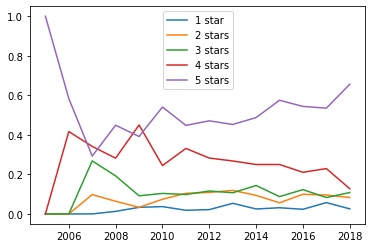

In [29]:
x_time = [val.year_only for val in df_order.select('year_only').collect()]

y_ans_val1 = [val.count_stars1/val.count_year for val in df_order.select('count_stars1','count_year').collect()]

y_ans_val2 = [val.count_stars2/val.count_year for val in df_order.select('count_stars2','count_year').collect()]

y_ans_val3 = [val.count_stars3/val.count_year for val in df_order.select('count_stars3','count_year').collect()]

y_ans_val4 = [val.count_stars4/val.count_year for val in df_order.select('count_stars4','count_year').collect()]

y_ans_val5 = [val.count_stars5/val.count_year for val in df_order.select('count_stars5','count_year').collect()]

plt.plot(x_time, y_ans_val1,x_time, y_ans_val2,x_time, y_ans_val3,x_time, y_ans_val4,x_time, y_ans_val5)
plt.gca().legend(('1 star','2 stars','3 stars','4 stars','5 stars'))

plt.show()

In [38]:
import time

In [39]:
start_time = time.time()

x_time = df_order.select("year_only").rdd.flatMap(lambda x: x).collect()

mvv1 = df_order.select("count_stars1").rdd.flatMap(lambda x: x).collect()
mvv2 = df_order.select("count_stars2").rdd.flatMap(lambda x: x).collect()
mvv3 = df_order.select("count_stars3").rdd.flatMap(lambda x: x).collect()
mvv4 = df_order.select("count_stars4").rdd.flatMap(lambda x: x).collect()
mvv5 = df_order.select("count_stars5").rdd.flatMap(lambda x: x).collect()


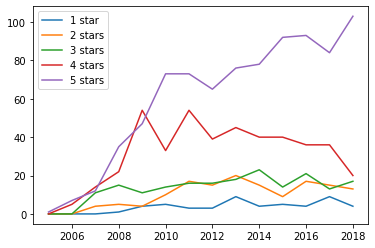

In [40]:
plt.plot(x_time, mvv1,x_time, mvv2,x_time, mvv3,x_time, mvv4,x_time, mvv5)

plt.gca().legend(('1 star','2 stars','3 stars','4 stars','5 stars'))

plt.show()

In [41]:
elapsed_time = time.time() - start_time
print(elapsed_time)

338.1092700958252


In [42]:
start_time = time.time()

x_time = [val.year_only for val in df_order.select('year_only').collect()]

y_ans_val1 = [val.count_stars1 for val in df_order.select('count_stars1').collect()]

y_ans_val2 = [val.count_stars2 for val in df_order.select('count_stars2').collect()]

y_ans_val3 = [val.count_stars3 for val in df_order.select('count_stars3').collect()]

y_ans_val4 = [val.count_stars4 for val in df_order.select('count_stars4').collect()]

y_ans_val5 = [val.count_stars5 for val in df_order.select('count_stars5').collect()]

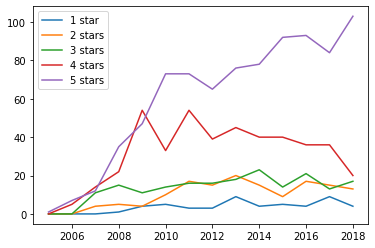

In [43]:
plt.plot(x_time, y_ans_val1,x_time, y_ans_val2,x_time, y_ans_val3,x_time, y_ans_val4,x_time, y_ans_val5)
plt.gca().legend(('1 star','2 stars','3 stars','4 stars','5 stars'))

plt.show()

In [44]:
elapsed_time = time.time() - start_time
print(elapsed_time)

311.8744623661041


In [ ]:
#--9e1ONYQuAa-CB_Rrw7Tw   tiQQqJ5ymf_XWzyF9ywArw

In [48]:
pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [2]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [41]:
req = open('dados_yelpapi.txt','r')
#data = req.read()

In [42]:
type(data)

str

In [5]:
df_business = df.groupBy('business_id').agg(avg('stars'),stddev('stars'))
df_business.show()

+--------------------+------------------+------------------+
|         business_id|        avg(stars)|stddev_samp(stars)|
+--------------------+------------------+------------------+
|f4mh1Y0rnvbJRfQ3j...| 3.888888888888889|0.8831048713694643|
|cKwg6HFaLYXl7Ar0r...|3.7777777777777777|1.8005082797253327|
|jcpgiXF0PCyS9hrvq...| 4.333333333333333|1.2909944487358056|
|R_M4P9XetEM-aLE7e...|3.9545454545454546|1.3682864437711102|
|DEBqmgxv2yhJ93LqG...|3.8378378378378377|1.3852504895934594|
|Cml4Yt5cTx64cOMan...| 2.933333333333333|1.9073791542572858|
|bo3SQVtErnMOqO6lk...|3.7788461538461537|1.1902249992825316|
|Cl-xl1vTUwHeaGgBx...|3.7883597883597884| 1.450484863054038|
|oIEmXWLtoh5blz-iw...|3.7533333333333334| 1.725982520176626|
|Op2IR4FffXZ5KXYFn...| 3.404494382022472|1.5791187208779367|
|yB5FMuc9Y3oyhsOmu...|2.4782608695652173|1.8554481256654882|
|cEqOh78v1g1RCWHyu...|3.4473684210526314| 1.266989801811655|
|lt8IW9Bpy9GMeKGxy...|               3.8|1.6897255439251382|
|uC3qwaxsOkdJzpOc0...|3.

In [6]:
list_business = df_business.select('business_id').rdd.flatMap(lambda x: x).collect()

In [74]:
import json


req = open('dados_yelpapi.txt','r')
fl =req.readlines()
bs = 0
for x in fl:
    x=x.replace("'s", 's')
    x=x.replace("'", '"')
    x=x.replace("None", '{"latitude": 0.0, "longitude": 0.0}')
#     try:
    if x[0] == '{' and x[2]!='m':
        print(x)
        y = json.loads(x)
        for i in range (10):
            try:
                print (bs,y[str('bs'+str(bs))])
            except:
                print("e")
            bs+=1
            if bs ==1069 or bs ==1099 or bs ==1249 or bs ==1389 or bs ==1469 or bs ==1899 or bs ==2049 or bs ==2319  or bs ==2369 or bs ==2639  or bs ==2949 or bs==3279 or bs==3449:
                bs+=10
#     except:
#         bs+=10
#         print("e")

    

{"bs0": {"coordinates": {"latitude": 35.3719073, "longitude": -80.7206466}, "categories": [{"title": "Cinema"}]}, "bs1": {"coordinates": {"latitude": 36.172607421875, "longitude": -115.122047424316}, "categories": [{"title": "Garage Door Services"}]}, "bs2": {"coordinates": {"latitude": 33.6832469, "longitude": -112.0874121}, "categories": [{"title": "Archery"}, {"title": "Sporting Goods"}]}, "bs3": {"coordinates": {"latitude": 33.3906017259375, "longitude": -111.864378489554}, "categories": [{"title": "Japanese"}, {"title": "Sushi Bars"}]}, "bs4": {"coordinates": {"latitude": 33.4251725237573, "longitude": -111.939736828208}, "categories": [{"title": "Sandwiches"}, {"title": "Salad"}, {"title": "Wraps"}]}, "bs5": {"coordinates": {"latitude": 33.5401229858398, "longitude": -112.133850097656}, "categories": [{"title": "Pizza"}, {"title": "Chicken Wings"}, {"title": "Sandwiches"}]}, "bs6": {"coordinates": {"latitude": 41.1392621013283, "longitude": -81.8635507409167}, "categories": [{"ti

1056 {'coordinates': {'latitude': 36.2333095306212, 'longitude': -115.052500404418}, 'categories': [{'title': 'Public Services & Government'}]}
1057 {'coordinates': {'latitude': 33.4525053490052, 'longitude': -111.789505600912}, 'categories': [{'title': 'American (New)'}]}
1058 {'coordinates': {'latitude': 41.4303616, 'longitude': -81.7332512}, 'categories': [{'title': 'Diners'}, {'title': 'Hot Dogs'}, {'title': 'Breakfast & Brunch'}]}
1059 {'coordinates': {'latitude': 35.204128, 'longitude': -80.808807}, 'categories': [{'title': 'American (Traditional)'}]}
{"bs1060": {"coordinates": {"latitude": 43.77963, "longitude": -79.41518}, "categories": [{"title": "Ramen"}]}, "bs1061": {"coordinates": {"latitude": 45.495401, "longitude": -73.6208071}, "categories": [{"title": "French"}, {"title": "Wine Bars"}, {"title": "Seafood"}]}, "bs1062": {"coordinates": {"latitude": 51.021592, "longitude": -114.143528}, "categories": [{"title": "Bowling"}]}, "bs1063": {"coordinates": {"latitude": 40.44042

1874 {'coordinates': {'latitude': 33.40333, 'longitude': -111.94851}, 'categories': [{'title': 'Garage Door Services'}]}
1875 {'coordinates': {'latitude': 36.026, 'longitude': -115.04646}, 'categories': [{'title': 'Tanning'}]}
1876 {'coordinates': {'latitude': 33.579943, 'longitude': -112.265929}, 'categories': [{'title': 'Sports Bars'}]}
1877 {'coordinates': {'latitude': 33.41547, 'longitude': -111.83318}, 'categories': [{'title': 'Comic Books'}, {'title': 'Toy Stores'}, {'title': 'Hobby Shops'}]}
1878 {'coordinates': {'latitude': 40.5479399, 'longitude': -80.03558}, 'categories': [{'title': 'Diners'}]}
1879 {'coordinates': {'latitude': 33.6165258, 'longitude': -111.9269887}, 'categories': [{'title': 'Dance Studios'}, {'title': 'Interval Training Gyms'}, {'title': 'Cardio Classes'}]}
{"bs1880": {"coordinates": {"latitude": 40.11049, "longitude": -88.24}, "categories": [{"title": "Pizza"}]}, "bs1881": {"coordinates": {"latitude": 36.0539460743294, "longitude": -115.169012}, "categories

3102 {'coordinates': {'latitude': 40.45184, 'longitude': -80.01836}, 'categories': [{'title': 'Dentists'}]}
3103 {'coordinates': {'latitude': 33.336669, 'longitude': -111.757424}, 'categories': [{'title': 'General Dentistry'}, {'title': 'Endodontists'}, {'title': 'Cosmetic Dentists'}]}
3104 {'coordinates': {'latitude': 45.903489, 'longitude': -74.236636}, 'categories': [{'title': 'Canadian (New)'}, {'title': 'Gastropubs'}]}
3105 {'coordinates': {'latitude': 43.71332, 'longitude': -79.36705}, 'categories': [{'title': 'Pizza'}, {'title': 'Italian'}]}
3106 {'coordinates': {'latitude': 33.3071404, 'longitude': -111.8603973}, 'categories': [{'title': 'Bakeries'}]}
3107 {'coordinates': {'latitude': 33.448315, 'longitude': -111.926013}, 'categories': [{'title': 'Hotels'}]}
3108 {'coordinates': {'latitude': 35.22628, 'longitude': -80.84303}, 'categories': [{'title': 'Bakeries'}]}
3109 {'coordinates': {'latitude': 51.04489, 'longitude': -114.06527}, 'categories': [{'title': 'Lounges'}]}
{"bs311

e
e
e
{"bs5370": {"coordinates": {"latitude": 45.4756941196506, "longitude": -73.5818610462799}, "categories": [{"title": "Gyms"}]}, "bs5371": {"coordinates": {"latitude": 41.63985, "longitude": -81.4064099}, "categories": [{"title": "Candy Stores"}, {"title": "Custom Cakes"}, {"title": "Cooking Classes"}]}, "bs5372": {"coordinates": {"latitude": 33.32168, "longitude": -111.9615}, "categories": [{"title": "Eyelash Service"}, {"title": "Hair Extensions"}]}, "bs5373": {"coordinates": {"latitude": 43.65621, "longitude": -79.38326}, "categories": [{"title": "Medical Spas"}, {"title": "Hair Removal"}, {"title": "Skin Care"}]}, "bs5374": {"coordinates": {"latitude": 33.3489126, "longitude": -111.9096342}, "categories": [{"title": "Cinema"}]}, "bs5375": {"coordinates": {"latitude": 43.80669, "longitude": -79.28878}, "categories": [{"title": "Donuts"}, {"title": "Coffee & Tea"}]}, "bs5376": {"coordinates": {"latitude": 36.1030101, "longitude": -115.1735187}, "categories": [{"title": "Mexican"}

e
e
e
e
{"bs7830": {"coordinates": {"latitude": 33.475962, "longitude": -112.065604}, "categories": [{"title": "Vape Shops"}, {"title": "Tobacco Shops"}]}, "bs7831": {"coordinates": {"latitude": 43.8178131, "longitude": -79.1172829}, "categories": [{"title": "Burgers"}, {"title": "Fast Food"}]}, "bs7832": {"coordinates": {"latitude": 43.6387482, "longitude": -79.626091}, "categories": [{"title": "Toy Stores"}, {"title": "Hobby Shops"}]}, "bs7833": {"coordinates": {"latitude": 41.525326, "longitude": -81.454987}, "categories": [{"title": "Photographers"}]}, "bs7834": {"coordinates": {"latitude": 41.6766891479492, "longitude": -81.3117370605469}, "categories": [{"title": "General Dentistry"}, {"title": "Orthodontists"}, {"title": "Cosmetic Dentists"}]}, "bs7835": {"coordinates": {"latitude": 36.3009212610372, "longitude": -115.286111734326}, "categories": [{"title": "Massage Therapy"}, {"title": "Waxing"}, {"title": "Skin Care"}]}, "bs7836": {"coordinates": {"latitude": 51.082451, "longi

e
e
e
{"bs10510": {"coordinates": {"latitude": 35.968136527204, "longitude": -115.187744204281}, "categories": [{"title": "Security Systems"}]}, "bs10511": {"coordinates": {"latitude": 40.3823661804199, "longitude": -80.0945358276367}, "categories": [{"title": "Sports Bars"}, {"title": "American (Traditional)"}]}, "bs10512": {"coordinates": {"latitude": 41.670724, "longitude": -81.368094}, "categories": [{"title": "Motorcycle Repair"}, {"title": "Motorcycle Dealers"}]}, "bs10513": {"coordinates": {"latitude": 36.172732, "longitude": -115.196506}, "categories": [{"title": "Shoe Stores"}]}, "bs10514": {"coordinates": {"latitude": 43.6241415473253, "longitude": -79.4900895522502}, "categories": [{"title": "Japanese"}, {"title": "Sushi Bars"}]}, "bs10515": {"coordinates": {"latitude": 43.107811, "longitude": -89.4975739}, "categories": [{"title": "Jewelry"}]}, "bs10516": {"coordinates": {"latitude": 43.66716, "longitude": -79.38798}, "categories": [{"title": "Pubs"}, {"title": "Fish & Chip

e
e
e
e
e
e
e
{"bs13400": {"coordinates": {"latitude": 36.032013, "longitude": -115.24344}, "categories": [{"title": "Dance Studios"}]}, "bs13401": {"coordinates": {"latitude": 35.1686287, "longitude": -80.8752213}, "categories": [{"title": "Cuban"}, {"title": "Colombian"}, {"title": "Arabian"}]}, "bs13402": {"coordinates": {"latitude": 36.0590996593237, "longitude": -115.046369209886}, "categories": [{"title": "Grocery"}, {"title": "Meat Shops"}, {"title": "Health Markets"}, {"title": "Delis"}]}, "bs13403": {"coordinates": {"latitude": 45.497141, "longitude": -73.408773}, "categories": [{"title": "Fast Food"}, {"title": "Poutineries"}, {"title": "Sandwiches"}]}, "bs13404": {"coordinates": {"latitude": 43.07243, "longitude": -89.38461}, "categories": [{"title": "Gay Bars"}, {"title": "Pubs"}]}, "bs13405": {"coordinates": {"latitude": 35.2160698726418, "longitude": -80.8829100430012}, "categories": [{"title": "American (Traditional)"}, {"title": "Burgers"}, {"title": "Chicken Wings"}]},

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [10]:
import json

# some JSON:
x =  '{ "name":"John", "age":30, "city":"New York"}'

# parse x:
y = json.loads(x)

# the result is a Python dictionary:
print(y["name"])

John


In [80]:
pip install ipywidgets 
#jupyter nbextension enable --py widgetsnbextension


Note: you may need to restart the kernel to use updated packages.


In [10]:

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [10]:
df_usr_biz = df.select('user_id','business_id').distinct()

In [15]:
df_usr_biz.count()-6685900

-224504

In [9]:
 df.select('user_id').distinct().show()

+--------------------+
|             user_id|
+--------------------+
|rs3pq6wRmaSIADCIn...|
|xS6kmkMXp0PRrFwkS...|
|aNOSjqQFsrfcgmFtO...|
|-9da1xk7zgnnfO1uT...|
|PLjruA-EMskWfirBU...|
|O-frog8VhICKAT0gr...|
|7o473jeLWW-zgKN-Q...|
|L1XxGWFJ3S7xBQCT8...|
|D2ljL5ejuqpa4f8fn...|
|CzkWUMIYDxUSetfCR...|
|5avk-VCo_6Bx65ct1...|
|oKWVVqPWVzq5s6nS4...|
|e5kxYMksMVWApEJdO...|
|f-6oae7TltlfJicUi...|
|NL9jmu5jSkCdMM-i9...|
|z6gjzFENiQf-K3lPy...|
|Al2g2P9gt057Julh1...|
|midS4e50ZmuOeGyNm...|
|yTr8nlIjQCJWc0ZIC...|
|yb0AdKzhYwQIlt47r...|
+--------------------+
only showing top 20 rows



In [11]:
df_display = df.select('text','stars','cool','funny','useful','date')
def f(x):
    df_display.show(x)

interact(f, x=5)


interactive(children=(IntSlider(value=5, description='x', max=15, min=-5), Output()), _dom_classes=('widget-in…

<function __main__.f(x)>

In [12]:
def f (x):
    print(x)

interact(f, x='ID do ');

interactive(children=(Text(value='ID do ', description='x'), Output()), _dom_classes=('widget-interact',))

In [14]:
input("aa: " )

aa: adasd


'adasd'

In [29]:
interact(stats_for_article_published_between,
        start_date=widgets.DatePicker(value=pd.to_datetime('2018-01-01')),
        end_date=widgets.DatePicker(value=pd.to_datetime('2019-01-01')))

NameError: name 'stats_for_article_published_between' is not defined

In [30]:
@interact(x=True, y=1.0)
def g(x, y):
    return (x, y)

interactive(children=(Checkbox(value=True, description='x'), FloatSlider(value=1.0, description='y', max=3.0, …

In [33]:
interact(f, x=['apples','oranges']);


ValueError: cannot find widget or abbreviation for argument: 'a'

In [35]:
from IPython.display import display
def f(a, b):
    display(a + b)
    return a+b

In [37]:
w = interactive(f, a=10, b=20)


interactive(children=(IntSlider(value=10, description='a', max=30, min=-10), IntSlider(value=20, description='…

In [41]:
interact_manual(f,i=FloatSlider(min=1e5, max=1e7, step=1e5));


NameError: name 'FloatSlider' is not defined

In [2]:
import pandas as pd

#business_df = pd.read_csv("business.csv")
business_spark = df.groupBy('business_id').agg(avg('stars'),stddev('stars'))

In [3]:
business_df = spark.read.format("csv").option("header", "true").load("business.csv")

In [4]:
business_df.head()

Row(idBusiness='f4mh1Y0rnvbJRfQ3jPkqzQ', Categorias='Cinema', Latitude='35.3719073', Longitude='-80.7206466')

In [5]:
business_df.show()

+--------------------+--------------------+----------------+-----------------+
|          idBusiness|          Categorias|        Latitude|        Longitude|
+--------------------+--------------------+----------------+-----------------+
|f4mh1Y0rnvbJRfQ3j...|              Cinema|      35.3719073|      -80.7206466|
|cKwg6HFaLYXl7Ar0r...|Garage Door Services| 36.172607421875|-115.122047424316|
|jcpgiXF0PCyS9hrvq...|             Archery|      33.6832469|     -112.0874121|
|R_M4P9XetEM-aLE7e...|            Japanese|33.3906017259375|-111.864378489554|
|DEBqmgxv2yhJ93LqG...|          Sandwiches|33.4251725237573|-111.939736828208|
|Cml4Yt5cTx64cOMan...|               Pizza|33.5401229858398|-112.133850097656|
|bo3SQVtErnMOqO6lk...|      American (New)|41.1392621013283|-81.8635507409167|
|Cl-xl1vTUwHeaGgBx...|             Chinese|       36.160407|        -115.3216|
|oIEmXWLtoh5blz-iw...|               Tires|33.4752117069912|-111.926503610399|
|Op2IR4FffXZ5KXYFn...|      American (New)|        4

In [6]:
outer_join = (business_spark.join(business_df, business_df.idBusiness == business_spark.business_id, how='outer')).drop('idBusiness')


In [7]:
outer_join.first()

Row(business_id='--9e1ONYQuAa-CB_Rrw7Tw', avg(stars)=4.125827814569536, stddev_samp(stars)=1.1076682299694773, Categorias='Steakhouses', Latitude='36.123183', Longitude='-115.16919')

In [8]:
import pyspark.sql.functions as f
outer_join.groupBy(outer_join.business_id).count().where(f.col('count') > 1).select(f.sum('count')).show()

+----------+
|sum(count)|
+----------+
|        10|
+----------+



In [60]:
df_business = outer_join.toPandas()

In [62]:
df_business.to_csv("df_business.csv",index=False)